In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import loggamma
from scipy.special import factorial
import tensorflow_probability as tfp
import numpy as np
import random

In [ ]:
def sample_py_urn(theta, alpha, n):
    """
    Samples the partition of [n] induced by PYP(theta, alpha)
    """
    cnts_n = np.array([1])
    data = np.zeros(n, dtype=int)
    data[0] = 0
    k = 1

    for idx in range(1, n):
        probas = np.concatenate([cnts_n - alpha, [theta + k * alpha]],
                                dtype=float)
        probas /= np.sum(probas)
        pos = np.random.choice(len(probas), p=probas)
        data[idx] = pos
        if pos == k:
            cnts_n = np.concatenate([cnts_n, [1]])
            k += 1
        else:
            cnts_n[pos] += 1

    return cnts_n, data


In [ ]:
def keep_sampling_py_urn(theta, alpha, cnts_old, data_old, m_new):
    """ Keeps sampling for additional m_new steps"""
    cnts_nm = np.copy(cnts_old)
    data = np.copy(data_old)
    n = len(data)
    k = len(cnts_nm)

    data = np.concatenate([data, np.zeros(m_new)])
    for idx in range(n, n+m_new):
        probas = np.concatenate([cnts_nm - alpha, [theta + k * alpha]], dtype=float)
        probas /= np.sum(probas)
        pos = np.random.choice(len(probas), p=probas)
        data[idx] = pos
        if pos == k:
            cnts_nm = np.concatenate([cnts_nm, [1]])
            k += 1
        else:
            cnts_nm[pos] += 1

    return cnts_nm, data

In [ ]:
def log_pocchammer(a,b):
    """
    Computes the log of the Pocchammer symbol (a)_(b) = Gamma(a+b) / Gamma(a)
    """
    a = np.atleast_1d(a)
    b = np.atleast_1d(b)
    if len(a) == 1 and len(b) > 1:
        a = np.repeat(a, len(b))
    if len(b) == 1 and len(a) > 1:
        b = np.repeat(b, len(a))

    out = np.zeros(len(b))
    out[a == 0] = 0.0
    wh = np.where(a > 0)[0]
    out[wh] = loggamma(a[wh] + b[wh]) - loggamma(a[wh])
    return out

In [ ]:
def log_predictive_dens(counts_first, counts_full, theta, sigma):
    """
    We ignore the terms P_0(dx^*_j)
    """
    n = np.sum(counts_first)
    kn = len(counts_first)
    m = np.sum(counts_full) - n
    knm = len(counts_full)

    out = - log_pocchammer(theta + n, m)
    out += np.sum(np.log(theta + np.arange(kn, knm) * sigma))
    out += np.sum(log_pocchammer(1 - sigma, counts_full - 1))
    out -= np.sum(log_pocchammer(1 - sigma, counts_first - 1))
    return out

In [ ]:
""" first version simulation, random modification to the conditioning sample """
L = 5000
ratio_privacy_0 = np.zeros(L)
ratio_privacy_1 = np.zeros(L)
ratio_privacy_2 = np.zeros(L)
N = 10000 # 10.000 quite good
M = 2000 # 1.000 quite good
theta = 1 #theta around 1 is good
sigma = 3/4 # case sigma = 0 we recover the Dirichlet process (alti valori di sigma danno molti problemi)
private_cnts, private_data = sample_py_urn(theta, sigma, N)  # N sample from the PYP

for l in range(L):

  option = 0
  solo_dopo = 0

  # initialization
  x1nm = np.zeros(N+M)
  x1nm_mod_0 = np.zeros(N+M)
  x1nm_mod_1 = np.zeros(N+M)
  x1nm_mod_2 = np.zeros(N+M)
  x1n_mod_0 = np.zeros(N)
  x1n_mod_1 = np.zeros(N)
  x1n_mod_2 = np.zeros(N)
  #---------------------------

  pred_cnts, pred_data = keep_sampling_py_urn(theta, sigma, private_cnts, private_data, M) # M sample from the PYP continuing the N before

  # data according to the random partition
  unique_values_nm = np.random.rand(len(pred_cnts))
  for i in range(len(pred_cnts)):
    x1nm += (pred_data == i)*unique_values_nm[i]
  #---------------------------

  # x_1^',...,x_n initialization
  x1n_mod_0 = x1nm[:N].copy()
  x1n_mod_1 = x1nm[:N].copy()
  x1n_mod_2 = x1nm[:N].copy()
  #---------------------------

  # counts related to the observation that I'm going to change
  m_l = np.count_nonzero(x1nm[N:] == x1n_mod_1[0]) #[-1] if I will change the last observation
  r_ln = np.count_nonzero(x1nm[:N] == x1n_mod_1[0])



  if(r_ln == 1): #possiamo escluderlo nella teoria, sono tanti i casi in cui r_ln == 1 se sigma grande?
     option = 1
  #---------------------------

  # ATTENTION: unico caso in cui non funziona è quello in cui tutti i valori sono uguali in uno dei due sotto array i.e x1nm[:N] contiene un solo valore o x1nm[N:] contiene un solo valore perchè in quel caso continua ad iterare
  while(True):
    tmp_0 = np.random.choice(x1nm[1:N]) #scelgo un elemento tra i primi N eccetto quello che sto sostituendo ([:N-1] in the case of the last observation)
    if(tmp_0 != x1n_mod_0[0]): # se diverso da quello che sto sostituendo, assumption of differential privacy
      break

  x1n_mod_0[0] = tmp_0 # x_n' equal to one among x_2,..,x_n ([1:N] for [0]) ([0:N-1] for [-1])

  while(True):
    tmp_1 = np.random.choice(x1nm[N:])
    if(tmp_1 != x1n_mod_1[0]):
      break

  r_jnm = np.count_nonzero(x1nm == tmp_1)
  r_jn = np.count_nonzero(x1nm[:N] == tmp_1)

  if(r_jn == 0):
    solo_dopo = 1

  x1n_mod_1[0] = tmp_1 # x_n' equal to one among x_{n+1},...,x_{n+m}

  x1n_mod_2[0] = np.random.rand(1)

  x1nm_mod_0 = np.concatenate([x1n_mod_0,x1nm[N:].copy()])
  x1nm_mod_1 = np.concatenate([x1n_mod_1,x1nm[N:].copy()])
  x1nm_mod_2 = np.concatenate([x1n_mod_2,x1nm[N:].copy()])

  _, counts_nm_mod_0 = np.unique(x1nm_mod_0,return_counts = True)
  _, counts_n_mod_0 = np.unique(x1n_mod_0 ,return_counts = True)
  _, counts_nm_mod_1 = np.unique(x1nm_mod_1,return_counts = True)
  _, counts_n_mod_1 = np.unique(x1n_mod_1 ,return_counts = True)
  _, counts_nm_mod_2 = np.unique(x1nm_mod_2,return_counts = True)
  _, counts_n_mod_2 = np.unique(x1n_mod_2,return_counts = True)

  log_predictive_dens_num = log_predictive_dens(private_cnts, pred_cnts, theta, sigma)
  ratio_privacy_0[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_0, counts_nm_mod_0, theta, sigma))
  ratio_privacy_1[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_1, counts_nm_mod_1, theta, sigma))
  ratio_privacy_2[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_2, counts_nm_mod_2, theta, sigma))


  if (ratio_privacy_0[l] > np.e**2 or 1/ratio_privacy_0[l] > np.e**2 ): #private_cnts,private_data,counts_n_mod_0,counts_nm_mod_0
    print("case 0")
    print('private data changed frequency one:', option)
    print(len(counts_nm_mod_0))
    print(len(counts_n_mod_0))
    print(len(private_cnts))
    print(len(pred_cnts))
    print("----------------------------------------------")
  if ((ratio_privacy_1[l] > np.e**2 or 1/ratio_privacy_1[l] > np.e**2)): #private_cnts,private_data,counts_n_mod_1,counts_nm_mod_1
    print("case 1")
    print('private data changed frequency one:', option)
    print(len(private_cnts))
    print(len(pred_cnts))
    print(ratio_privacy_1[l])
    print(1/ratio_privacy_1[l])
    print('my value estimated', 1/(theta + len(private_cnts)*sigma)*(r_ln - sigma -1)/(r_ln - sigma + m_l - 1)*(r_jnm - sigma))
    print(1/(theta + len(private_cnts)*sigma))
    print('private data changed frequency one:', option)
    print(r_ln - sigma -1)
    print(r_ln - sigma + m_l - 1)
    print(r_jnm - sigma)
    print(r_jnm)
    print(r_jn)
    print(m_l)
    print(r_ln)
    print('the unique value is present only in the enlarged sample:', solo_dopo)
    print("-----------------------------------------------")
  if (ratio_privacy_2[l] > np.e**2 or 1/ratio_privacy_2[l] > np.e**2 ): #private_cnts,private_data,counts_n_mod_2,counts_nm_mod_2
    print("case 3")
    print('private data changed frequency one:', option)
    print(len(counts_nm_mod_2))
    print(len(counts_n_mod_2))
    print(len(private_cnts))
    print(len(pred_cnts))
    print("----------------------------------------------")

#print(ratio_privacy)

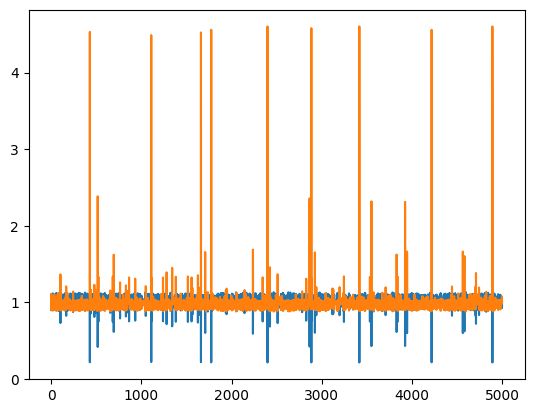

In [ ]:
plt.plot(ratio_privacy_0)
plt.plot(1/ratio_privacy_0)
plt.show()

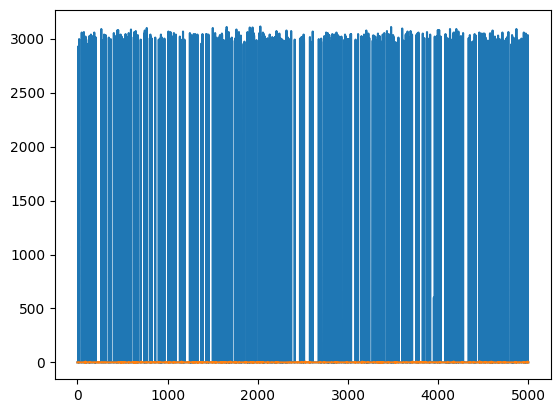

In [ ]:
plt.plot(ratio_privacy_1)
plt.plot(1/ratio_privacy_1)
plt.show()

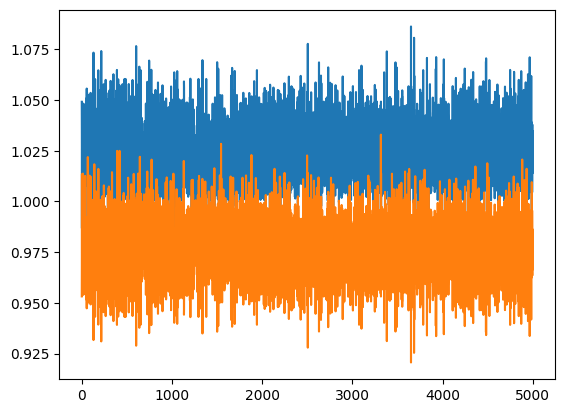

In [ ]:
plt.plot(ratio_privacy_2)
plt.plot(1/ratio_privacy_2)
plt.show()

In [ ]:
#print(ratio_privacy)
print(np.where(ratio_privacy_0> np.e**2))
print(np.where(1/ratio_privacy_0 > np.e**2))
print(len(np.where(ratio_privacy_0 > np.e**2)[0])/L)
print(1/N)

(array([], dtype=int64),)
(array([], dtype=int64),)
0.0
0.0001


In [ ]:
n = 10000
m = 1000
sigma = 0
j = 700
theta = 1
print(1 - np.exp(log_pocchammer(n - j*sigma,m) - log_pocchammer(theta + n,m)))
print(1 - np.exp(loggamma(n- n*sigma + m) - loggamma(n)- log_pocchammer(theta + n,m)))
print(1/n)

[0.09090909]
[0.09090909]
0.0001


In [ ]:
""" second version, we save all the 3 possible modification """
L = 500
ratio_privacy_0 = np.zeros(L)
ratio_privacy_1 = np.zeros(L)
ratio_privacy_2 = np.zeros(L)
N = 10000 # 10.000 quite good
M = 1000 # 1.000 quite good
q = 100
theta = q*10000 #theta around 1 is good
sigma = -10000 # case sigma = 0 we recover the Dirichlet process (alti valori di sigma danno molti problemi)
private_cnts, private_data = sample_py_urn(theta, sigma, N)  # N sample from the PYP

for l in range(L):

  option = 0
  solo_dopo = 0

  # initialization
  x1nm = np.zeros(N+M)
  x1nm_mod_0 = np.zeros(N+M)
  x1nm_mod_1 = np.zeros(N+M)
  x1nm_mod_2 = np.zeros(N+M)
  x1n_mod_0 = np.zeros(N)
  x1n_mod_1 = np.zeros(N)
  x1n_mod_2 = np.zeros(N)
  #---------------------------

  pred_cnts, pred_data = keep_sampling_py_urn(theta, sigma, private_cnts, private_data, M) # M sample from the PYP continuing the N before

  # data according to the random partition
  unique_values_nm = np.random.rand(len(pred_cnts))
  for i in range(len(pred_cnts)):
    x1nm += (pred_data == i)*unique_values_nm[i]
  #---------------------------

  # x_1^',...,x_n initialization
  x1n_mod_0 = x1nm[:N].copy()
  x1n_mod_1 = x1nm[:N].copy()
  x1n_mod_2 = x1nm[:N].copy()
  #---------------------------

  # counts related to the observation that I'm going to change
  m_l = np.count_nonzero(x1nm[N:] == x1n_mod_1[0]) #[-1] if I will change the last observation
  r_ln = np.count_nonzero(x1nm[:N] == x1n_mod_1[0])



  if(r_ln == 1): #possiamo escluderlo nella teoria, sono tanti i casi in cui r_ln == 1 se sigma grande?
     option = 1
     print("option_1")
  #---------------------------

  # ATTENTION: unico caso in cui non funziona è quello in cui tutti i valori sono uguali in uno dei due sotto array i.e x1nm[:N] contiene un solo valore o x1nm[N:] contiene un solo valore perchè in quel caso continua ad iterare
  while(True):
    tmp_0 = np.random.choice(x1nm[1:N]) #scelgo un elemento tra i primi N eccetto quello che sto sostituendo ([:N-1] in the case of the last observation)
    if(tmp_0 != x1n_mod_0[0]): # se diverso da quello che sto sostituendo, assumption of differential privacy
      break

  x1n_mod_0[0] = tmp_0 # x_n' equal to one among x_2,..,x_n ([1:N] for [0]) ([0:N-1] for [-1])

  while(True):
    tmp_1 = np.random.choice(x1nm[N:])
    if(tmp_1 != x1n_mod_1[0]):
      break

  r_jnm = np.count_nonzero(x1nm == tmp_1)
  r_jn = np.count_nonzero(x1nm[:N] == tmp_1)

  if(r_jn == 0):
    solo_dopo = 1

  x1n_mod_1[0] = tmp_1 # x_n' equal to one among x_{n+1},...,x_{n+m}

  x1n_mod_2[0] = np.random.rand(1)

  x1nm_mod_0 = np.concatenate([x1n_mod_0,x1nm[N:].copy()])
  x1nm_mod_1 = np.concatenate([x1n_mod_1,x1nm[N:].copy()])
  x1nm_mod_2 = np.concatenate([x1n_mod_2,x1nm[N:].copy()])

  _, counts_nm_mod_0 = np.unique(x1nm_mod_0,return_counts = True)
  _, counts_n_mod_0 = np.unique(x1n_mod_0 ,return_counts = True)
  _, counts_nm_mod_1 = np.unique(x1nm_mod_1,return_counts = True)
  _, counts_n_mod_1 = np.unique(x1n_mod_1 ,return_counts = True)
  _, counts_nm_mod_2 = np.unique(x1nm_mod_2,return_counts = True)
  _, counts_n_mod_2 = np.unique(x1n_mod_2,return_counts = True)

  log_predictive_dens_num = log_predictive_dens(private_cnts, pred_cnts, theta, sigma)
  ratio_privacy_0[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_0, counts_nm_mod_0, theta, sigma))
  ratio_privacy_1[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_1, counts_nm_mod_1, theta, sigma))
  ratio_privacy_2[l] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod_2, counts_nm_mod_2, theta, sigma))


  if (ratio_privacy_0[l] > np.e**2 or 1/ratio_privacy_0[l] > np.e**2 ): #private_cnts,private_data,counts_n_mod_0,counts_nm_mod_0
    print("case 0")
    print('private data changed frequency one:', option)
    print(len(counts_nm_mod_0))
    print(len(counts_n_mod_0))
    print(len(private_cnts))
    print(len(pred_cnts))
    print("----------------------------------------------")
  if ((ratio_privacy_1[l] > np.e**2 or 1/ratio_privacy_1[l] > np.e**2)): #private_cnts,private_data,counts_n_mod_1,counts_nm_mod_1
    print("case 1")
    print('private data changed frequency one:', option)
    print(len(private_cnts))
    print(len(pred_cnts))
    print(ratio_privacy_1[l])
    print(1/ratio_privacy_1[l])
    print('my value estimated', 1/(theta + len(private_cnts)*sigma)*(r_ln - sigma -1)/(r_ln - sigma + m_l - 1)*(r_jnm - sigma))
    print(1/(theta + len(private_cnts)*sigma))
    print('private data changed frequency one:', option)
    print(r_ln - sigma -1)
    print(r_ln - sigma + m_l - 1)
    print(r_jnm - sigma)
    print(r_jnm)
    print(r_jn)
    print(m_l)
    print(r_ln)
    print('the unique value is present only in the enlarged sample:', solo_dopo)
    print("-----------------------------------------------")
  if (ratio_privacy_2[l] > np.e**2 or 1/ratio_privacy_2[l] > np.e**2 ): #private_cnts,private_data,counts_n_mod_2,counts_nm_mod_2
    print("case 3")
    print('private data changed frequency one:', option)
    print(len(counts_nm_mod_2))
    print(len(counts_n_mod_2))
    print(len(private_cnts))
    print(len(pred_cnts))
    print("----------------------------------------------")

#print(ratio_privacy)

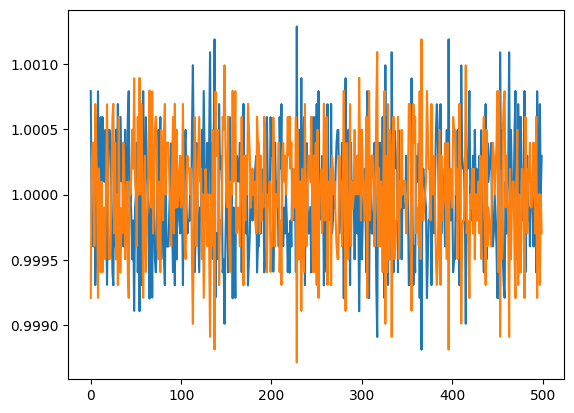

In [ ]:
plt.plot(ratio_privacy_0)
plt.plot(1/ratio_privacy_0)
plt.show()

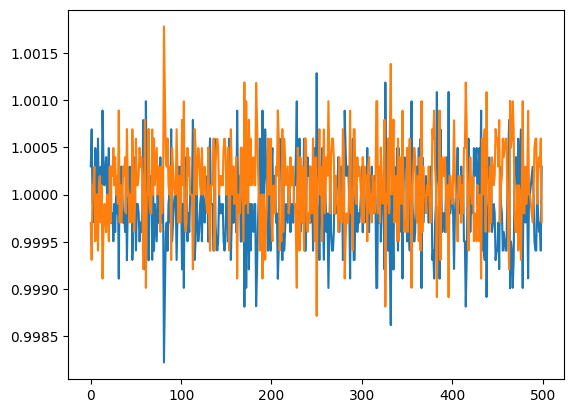

In [ ]:
plt.plot(ratio_privacy_1)
plt.plot(1/ratio_privacy_1)
plt.show()

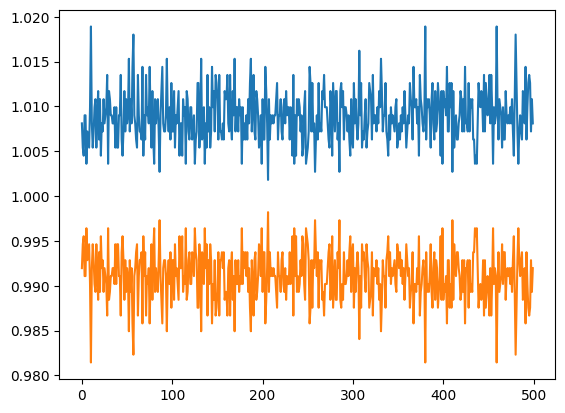

In [ ]:
plt.plot(ratio_privacy_2)
plt.plot(1/ratio_privacy_2)
plt.show()

In [ ]:
""" last implementation, see thesis notes section "Back to simulation """
import time
 # current time in milliseconds
L = 100 #numero di z che fisso
J = 100 #numero di y che fisso
K = 100 #numero di x che fisso
ratio_privacy= np.zeros(L*J*K)
np.random.seed(0)
c = 0
N = 1000 # 10.000 quite good
M = 500 # 1.000 quite good
theta = 1
sigma = 0 # case sigma = 0 we recover the Dirichlet process (alti valori di sigma danno molti problemi)
for k in range(K):
  t = 1000 * time.time()
  np.random.seed(int(t) % 2**32)
  private_cnts, private_data = sample_py_urn(theta, sigma, N)  # N sample from the PYP

  for l in range(L):

    # initialization
    x1nm = np.zeros(N+M)
    x1nm_mod = np.zeros(N+M)
    x1n_mod = np.zeros(N)
    #---------------------------
    t = 1000 * time.time()
    np.random.seed(int(t) % 2**32)
    pred_cnts, pred_data = keep_sampling_py_urn(theta, sigma, private_cnts, private_data, M) # M sample from the PYP continuing the N before

    # data according to the random partition

    t = 1000 * time.time()
    np.random.seed(int(t) % 2**32)
    unique_values_nm = np.random.rand(len(pred_cnts))
    for i in range(len(pred_cnts)):
      x1nm += (pred_data == i)*unique_values_nm[i]
    #---------------------------

    # x_1^',...,x_n initialization
    x1n_mod = x1nm[:N].copy()
    #---------------------------
    for j in range(J):
    # ATTENTION: unico caso in cui non funziona è quello in cui tutti i valori sono uguali in uno dei due sotto array i.e x1nm[:N] contiene un solo valore o x1nm[N:] contiene un solo valore perchè in quel caso continua ad iterare
      t = 1000 * time.time()
      np.random.seed(int(t) % 2**32)
      choice = np.random.choice([1,2,3]).item()
      if(choice == 1):
        while(True):
          t = 1000 * time.time()
          np.random.seed(int(t) % 2**32)
          tmp = np.random.choice(x1nm[:N-1]) #scelgo un elemento tra i primi N eccetto quello che sto sostituendo ([:N-1] in the case of the last observation)
          if(tmp != x1n_mod[-1]): # se diverso da quello che sto sostituendo, assumption of differential privacy
            x1n_mod[-1] = tmp # x_n' equal to one among x_2,..,x_n ([1:N] for [0]) ([0:N-1] for [-1])
            break
      if(choice == 2):
        while(True):
          t = 1000 * time.time()
          np.random.seed(int(t) % 2**32)
          unique_values = np.unique(x1nm[N+1:]) # aggiungere un break se sono tutti uguali
          if(len(unique_values) == 1):
            tmp = unique_values.item()
            break
          tmp = np.random.choice(unique_values)
          if(tmp != x1n_mod[-1]):
            x1n_mod[-1] = tmp # x_n' equal to one among x_{n+1},...,x_{n+m}
            break
      if(choice == 3):
        x1n_mod[-1] = np.random.rand(1).item()

      x1nm_mod = np.concatenate([x1n_mod,x1nm[N:].copy()])
      _, counts_nm_mod = np.unique(x1nm_mod, return_counts = True)
      _, counts_n_mod = np.unique(x1n_mod ,return_counts = True)
      log_predictive_dens_num = log_predictive_dens(private_cnts, pred_cnts, theta, sigma)
      ratio_privacy[c] = np.exp(log_predictive_dens_num  - log_predictive_dens(counts_n_mod, counts_nm_mod, theta, sigma)).item()
      c = c + 1

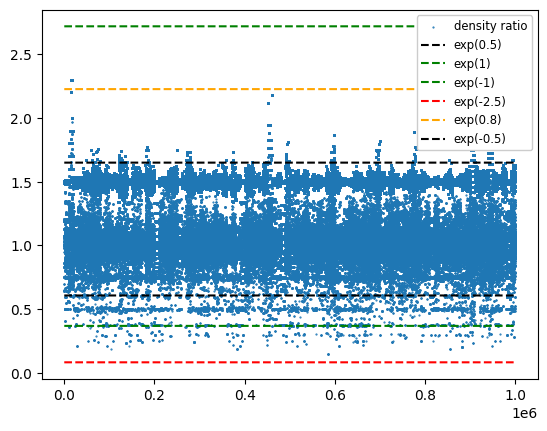

In [ ]:
plt.scatter(range(1,len(ratio_privacy)+1), ratio_privacy, color='#1f77b4', label='density ratio', s=0.3)
plt.plot(np.exp(0.5)*np.ones(len(ratio_privacy)), linestyle='--', color = 'black', label='exp(0.5)')
plt.plot(np.exp(1)*np.ones(len(ratio_privacy)), linestyle='--', color = 'green', label='exp(1)')
plt.plot(np.exp(-1)*np.ones(len(ratio_privacy)), linestyle='--', color = 'green', label='exp(-1)')
plt.plot(np.exp(-2.5)*np.ones(len(ratio_privacy)), linestyle='--', color = 'red', label='exp(-2.5)')
plt.plot(np.exp(0.8)*np.ones(len(ratio_privacy)), linestyle='--', color = 'orange', label='exp(0.8)')
plt.plot(np.exp(-0.5)*np.ones(len(ratio_privacy)), linestyle='--', color = 'black', label='exp(-0.5)')
plt.legend(fontsize='small', loc='upper right',framealpha=1.0)
plt.show()

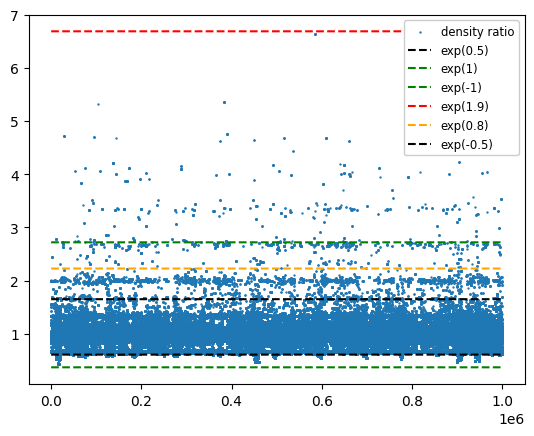

In [ ]:
plt.scatter(range(1,len(ratio_privacy)+1), 1/ratio_privacy, color='#1f77b4', label='density ratio', s=0.5)
plt.plot(np.exp(0.5)*np.ones(len(ratio_privacy)), linestyle='--', color = 'black', label='exp(0.5)')
plt.plot(np.exp(1)*np.ones(len(ratio_privacy)), linestyle='--', color = 'green', label='exp(1)')
plt.plot(np.exp(-1)*np.ones(len(ratio_privacy)), linestyle='--', color = 'green', label='exp(-1)')
plt.plot(np.exp(1.9)*np.ones(len(ratio_privacy)), linestyle='--', color = 'red', label='exp(1.9)')
plt.plot(np.exp(0.8)*np.ones(len(ratio_privacy)), linestyle='--', color = 'orange', label='exp(0.8)')
plt.plot(np.exp(-0.5)*np.ones(len(ratio_privacy)), linestyle='--', color = 'black', label='exp(-0.5)')
plt.legend(fontsize='small', loc='upper right',framealpha=1.0)
plt.show()
